### Imports

In [2]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [3]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader, random_split
from skimage import io
import matplotlib.pyplot as plt

In [4]:
def train_epoch(model, dataloader, optimizer, loss_f, device):
    model.train()
    cumulative_loss = 0.0
    num_correct = 0
    num_total = 0

    for img, label in dataloader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        predictions = model(img)
        loss = loss_f(predictions, label)
        cumulative_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(predictions, dim=1)
        num_correct += (predicted == label).sum().item()
        num_total += label.shape[0]

    average_loss = cumulative_loss / len(dataloader)
    average_acc = 100 * num_correct / num_total

    return average_loss, average_acc


def validate_epoch(model, dataloader, loss_f, device):
    model.eval()
    cumulative_loss = 0.0
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for img, label in dataloader:
            img, label = img.to(device), label.to(device)
            predictions = model(img)
            loss = loss_f(predictions, label)
            cumulative_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(predictions, dim=1)
            num_correct += (predicted == label).sum().item()
            num_total += label.shape[0]

    average_loss = cumulative_loss / len(dataloader)
    average_acc = 100 * num_correct / num_total

    return average_loss, average_acc

In [5]:
import matplotlib.pyplot as plt


def plot_performance(train_acc, test_acc, train_loss, test_loss, epochs):


    epochs_range = range(1, epochs + 1)


    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Adjust the size as needed
    fig.suptitle('Training and Testing Performance')


    # train acc
    axes[0].plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training Accuracy')
    axes[0].legend()
    axes[0].grid(True)


    # test acc
    axes[1].plot(epochs_range, test_acc, label='Testing Accuracy', color='orange', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_title('Testing Accuracy')
    axes[1].legend()
    axes[1].grid(True)


    # train loss
    axes[2].plot(epochs_range, train_loss, label='Training Loss', marker='o', linestyle='--')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Training Loss')
    axes[2].legend()
    axes[2].grid(True)


    # test loss
    axes[3].plot(epochs_range, test_loss, label='Testing Loss', color='orange', marker='o', linestyle='--')
    axes[3].set_xlabel('Epochs')
    axes[3].set_title('Testing Loss')
    axes[3].legend()
    axes[3].grid(True)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [6]:
## Batch Size
# train_batch_size = 10
# validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 20

### Data Paths

In [7]:
import torchvision.datasets as datasets

# Dataset Transformation
dataroot_source = "/content/gdrive/MyDrive/MLDL/Final Project/OfficeHomeDataset_10072016/Art"
# dataroot_target = "../input/home-office-dataset/OfficeHomeDataset_10072016/Real World"

# Image dimensions in pixels
image_dim = 64

source_dataset = datasets.ImageFolder(root=dataroot_source,
                           transform=transforms.Compose([
                               transforms.Resize(image_dim),
                               transforms.CenterCrop(image_dim),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# target_dataset = datasets.ImageFolder(root=dataroot_target,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_dim),
#                                transforms.CenterCrop(image_dim),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

In [8]:
# Batch Size
batch_size = 128

# Existing DataLoader and Dataset
source_loader = torch.utils.data.DataLoader(source_dataset, batch_size=batch_size, shuffle=True)

# Length of dataset
dataset_size = len(source_loader.dataset)

# Calculate split sizes
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(source_loader.dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
len(test_loader)


4

In [25]:
# for images, labels in train_loader:
#     print('Image batch dimensions:', images.shape)
#     print('Image label dimensions:', labels.shape)
#     break

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


## Model Architecture

Finish building the U-net architecture below.

### VGG16

In [10]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

In [15]:
n_classes = 65

vgg16_model = vgg16(pretrained = True)
vgg16_model.features[0] = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
num_input_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_input_features, n_classes)

for param in vgg16_model.parameters():
    param.requires_grad = False
for param in vgg16_model.features[0].parameters():
    param.requires_grad = True
for param in vgg16_model.classifier[6].parameters():
    param.requires_grad = True

# If you are using a GPU for training, you should also tell PyTorch to move the model to the GPU
gpu_boole = torch.backends.mps.is_available()

# device = torch.device("cuda:0" if gpu_boole else "cpu")
device = torch.device("mps" if gpu_boole else "cpu")
vgg16_model = vgg16_model.to(device)

print(vgg16_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import time
learning_rate = 0.001
optimizer = torch.optim.Adam(vgg16_model.parameters(),lr=learning_rate)
loss_f = nn.CrossEntropyLoss()

training_losses = []
training_accs = []
test_losses = []
test_accs = []
best_test_loss = float('inf')

epochs_early_stopping = 20
epochs_min_change = 0.0001

num_epochs = 10
print("Start Training...")
for epoch in range(num_epochs):

    t0 = time.time()


    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")

    training_loss, training_acc = train_epoch(vgg16_model, train_loader, optimizer, loss_f, device)
    print(f"Training Loss: {training_loss:.4f}")
    training_losses.append(training_loss)
    training_accs.append(training_acc)

    ########################### Validation #####################################
    test_loss, test_acc = validate_epoch(vgg16_model, test_loader, loss_f, device)
    print(f"Validation Loss: {test_loss:.4f}")
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    if test_loss < (best_test_loss - epochs_min_change):
        print("Test Loss Improved from {:.4f} to {:.4f}".format(best_test_loss, test_loss))
        best_test_loss = test_loss
        epochs_early_stopping = 20
        torch.save(vgg16_model.state_dict(), 'vgg16_model_best.pth')
        print("Model saved as best_model.pth")
    else:
        epochs_early_stopping -= 1
        print(f"No improvement in test loss for {20 - epochs_early_stopping} consecutive epochs.")

    # Check if Early Stopping is needed
    if epochs_early_stopping == 0:
        print(f"Early stopping after {epoch + 1} epochs!")
        break

    t1 = time.time()

    total = t1-t0

    print("Epoch {} completed.".format(epoch + 1))
    print("Time: " + str(total))


Start Training...

EPOCH 1 of 10



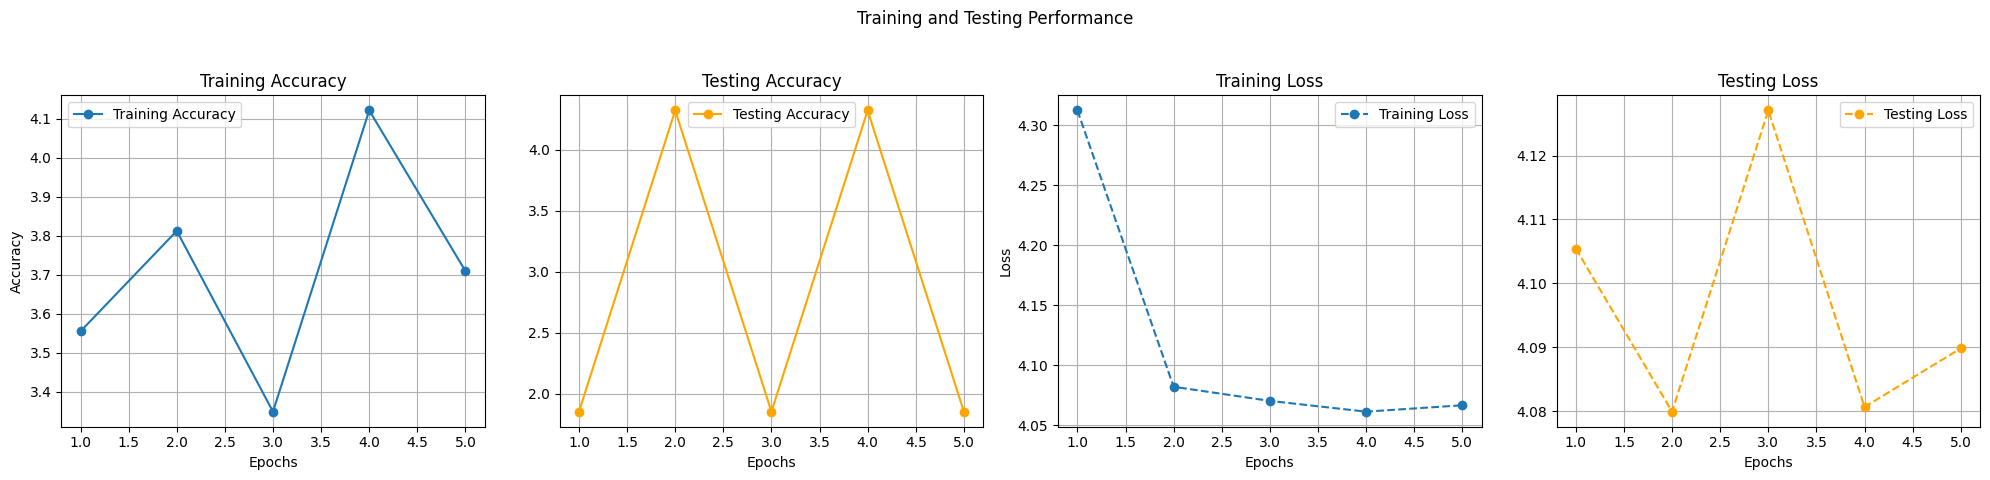

In [14]:
plot_performance(training_accs, test_accs, training_losses, test_losses, 5)